In [1]:
import numpy as np

from matplotlib import pyplot as plt

In [2]:
def Progonka(A, B, C, F):
    N = A.shape[0]
    X = np.zeros_like(A)
    
    beta = np.zeros_like(A)
    #phi = np.zeros((N, ))
    
    beta[0] = B[0] / A[0]
    X[0] = F[0] / A[0]
    
    for i in range(1, N):
        beta[i] = B[i] / (A[i] - beta[i - 1] * C[i])
        X[i] = (F[i] - C[i] * X[i - 1]) / (A[i] - beta[i - 1] * C[i])
    #X[-1] = phi[-1]
    for i in range(N-2, -1, -1):
        X[i] -=  X[i + 1] * beta[i]
    return X

In [3]:
def getDxCoeffs(h):
    h1 = h[:-1]
    h2 = h[1:]
    shape = (len(h) + 1, )
    A, B, C = np.zeros(shape), np.zeros(shape), np.zeros(shape)
    A[1:-1] = (h2 - h1) / (h2 * h1)
    B[1:-1] = (h1 / h2) / (h1 + h2)
    C[1:-1] = -(h2 / h1) / (h1 + h2) 
    return A, B, C

In [4]:
def getD2XCoeffs(h):
    h1 = h[:-1]
    h2 = h[1:]
    shape = (len(h) + 1, )
    A, B, C = np.zeros(shape), np.zeros(shape), np.zeros(shape)

    A[1:-1] = -2.0 / (h2 * h1)
    B[1:-1] = 2.0 / h2 / (h1 + h2)
    C[1:-1] = 2.0 / h1 / (h1 + h2)
    return A, B, C

In [5]:
def getCoeffs(r, sig, T, w):
    h = np.diff(w)
    
    A1, B1, C1 = getDxCoeffs(h)
    
    A2, B2, C2 = getD2XCoeffs(h)
    
    nu = -( r + sig ** 2 / 2 + np.exp(-w) / T )
    A = 0.5 * sig ** 2 * A2 + nu * A1
    B = 0.5 * sig ** 2 * B2 + nu * B1
    C = 0.5 * sig ** 2 * C2 + nu * C1
    
    return A, B, C

In [6]:
def solve(r, sig, T, Nt, z):
    w = np.log(-z)[::-1]
    
    u = np.zeros((Nt + 1, Nz + 1))
    F = np.zeros((Nz + 1, ))
    
    tau = T / Nt
    
    
    A, B, C = getCoeffs(r, sig, T, w)
    A_ = 1 - 0.5 * tau * A
    B_ = - 0.5 * tau * B
    C_ = - 0.5 * tau * C

    A_[0] = 1
    B_[0] = 0
    C_[0] = 0

    A_[-1] = 1
    B_[-1] = 0
    C_[-1] = 0

    
    for t in range(Nt):
        
        v = u[t, :]
        
        F[1:-1] = v[1:-1] + 0.5 * tau * (A[1:-1] * v[1:-1] + B[1:-1] * v[2:] + C[1:-1] * v[:-2])
        F[0] = (1 - np.exp(- r * tau * (t + 1) )  ) / (r * T)
        
        u[t + 1, :] = Progonka(A_, B_, C_, F)
    return u[::-1, ::-1]

In [33]:
def getRight(r, sig, t, T, z):
    if not isinstance(t, np.ndarray):
        t = np.asarray([t])
    if not isinstance(z, np.ndarray):
        z = np.asarray([z])
    t = t.reshape(-1, 1)
    tau = T - t
    return np.exp(- tau * r ) * z.reshape(1, -1) + (1 - np.exp(-tau * r) ) / (r * T)

In [106]:
r = 0.1
sig = 0.5

T = 1.2

Nt = 25
Nz = 50

In [107]:
eps = 1e-3

In [128]:
tmp = np.linspace(0, 1, Nz + 1) ** 2

zmin = -2
zmax = 3

z1 = zmin * tmp[::-1] - eps
z2 = np.linspace(0, zmax, Nz + 1)

tn = np.linspace(0, T, Nt + 1)

In [129]:
z1

array([-2.0010e+00, -1.9218e+00, -1.8442e+00, -1.7682e+00, -1.6938e+00,
       -1.6210e+00, -1.5498e+00, -1.4802e+00, -1.4122e+00, -1.3458e+00,
       -1.2810e+00, -1.2178e+00, -1.1562e+00, -1.0962e+00, -1.0378e+00,
       -9.8100e-01, -9.2580e-01, -8.7220e-01, -8.2020e-01, -7.6980e-01,
       -7.2100e-01, -6.7380e-01, -6.2820e-01, -5.8420e-01, -5.4180e-01,
       -5.0100e-01, -4.6180e-01, -4.2420e-01, -3.8820e-01, -3.5380e-01,
       -3.2100e-01, -2.8980e-01, -2.6020e-01, -2.3220e-01, -2.0580e-01,
       -1.8100e-01, -1.5780e-01, -1.3620e-01, -1.1620e-01, -9.7800e-02,
       -8.1000e-02, -6.5800e-02, -5.2200e-02, -4.0200e-02, -2.9800e-02,
       -2.1000e-02, -1.3800e-02, -8.2000e-03, -4.2000e-03, -1.8000e-03,
       -1.0000e-03])

In [130]:
u = solve(r, sig, T, Nt, z1)
v = getRight(r, sig, tn, T, z2)

In [131]:
h = np.c_[u, v]
z = np.r_[z1, z2]

In [132]:
w = getRight(r, sig, tn, T, z)

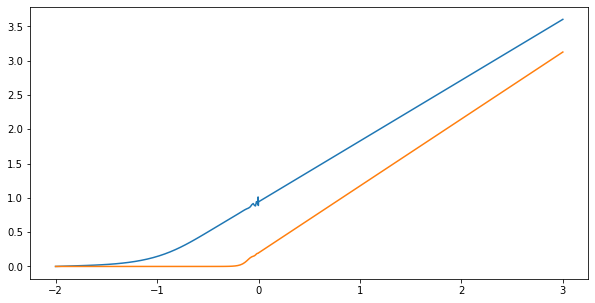

In [133]:
plt.figure(figsize=(10, 5))
for t in range(Nt)[::20]:
    plt.plot(z, h[t, :])
    plt.grid()

In [134]:
from scipy.interpolate import interp1d

from monte_carlo import *

In [135]:
S0 = 2.0
K0 = S0
Kn = K0 * np.linspace(0.3, 1.8, 20)

In [136]:
Nsim = 1000

error = 0.584997%
error = 0.585188%
error = 0.784830%
error = 0.145298%


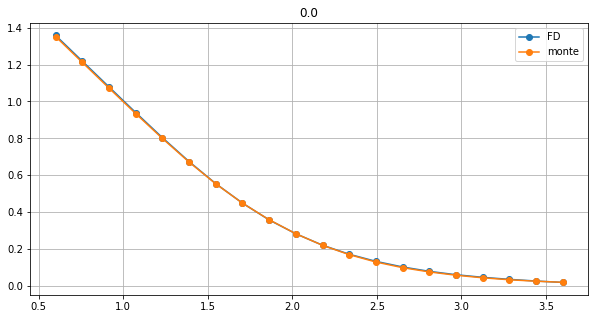

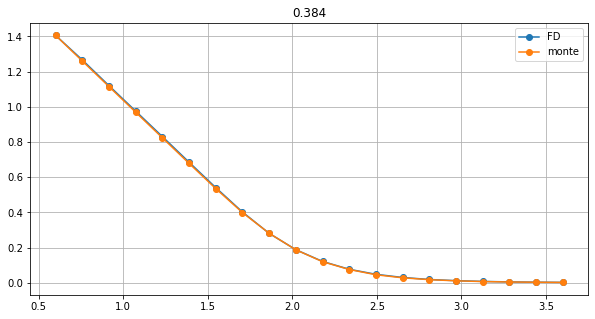

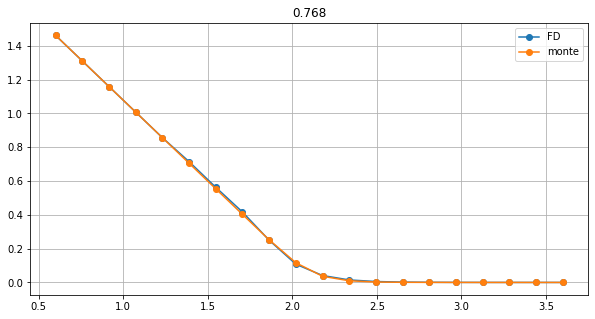

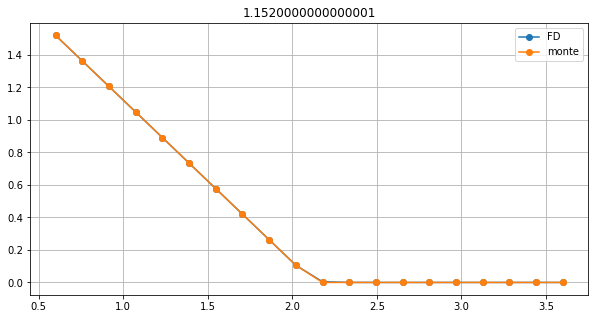

In [137]:
for nt in range(0, Nt, Nt // 3):

    t = tn[nt]
    
    St = S0 * np.exp(r * t)

    It = 0.5 * (St + S0) * t

    z_ = (It / T - Kn) / St

    Cmonte = MonteCarloArithmeticMean(r, sig, t, T, St, It, Kn, Nsim, 200)
    
    tmp = interp1d(z, h[nt, :], kind='linear')
    
    h_ = St * tmp(z_)
    err = 100 * np.linalg.norm(h_ - Cmonte['MC_MM']) / np.linalg.norm(Cmonte['MC_MM'])
    print(f'error = {err:4f}%')
    
    plt.figure(figsize=(10, 5))
    plt.title(f'{t}')
    plt.plot(Kn, h_, '-o', label='FD')
    plt.plot(Kn, Cmonte['MC_MM'], '-o', label='monte')
    plt.grid()    
    plt.legend()